In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import EoN
from matplotlib import rc
import scipy
import random
import pandas as pd

In [2]:
# red cdmx 
# SI(E)R con parámetros de covid19
# probabilidad de detección X
# isolate I*x
# trace fracción x 
# id superspreaders
# isolate x 

# modelar cooperacion vs autoritarismo

#refinamientos: 

# - usar SEIR en lugar de SIR
# - compartimentos para hospitalizados etc... considerar diferentes niveles de cooperación

## Load CDMX network

In [3]:
#g = nx.read_graphml(path="results/red_cdmx.graphml")

In [4]:
#len(g.nodes())

In [5]:
g = nx.read_graphml(path="/home/gdj/GITS/ModularReopeningCDMX/g_cdmx_infomap.graphml")

In [6]:

len(g.nodes())

7216

## Run a simple SIR on it

In [7]:
iterations = 1
for counter in range(iterations): #run simulations
    fd = EoN.fast_SIR(G=g, 
                              tau=0.1, 
                              gamma=1, 
                              rho=1/len(g.nodes()), 
                              return_full_data=True
                             )

In [8]:
pd.DataFrame(data={"time"        : fd.t(),
                   "susceptible" : fd.S(),
                   "infected"    : fd.I(),
                   "recovered"   : fd.R(),
                  }
            )

,time,susceptible,infected,recovered
0,0.00000,7215,1,0
1,2.35296,7215,0,1


In [9]:
pd.DataFrame(fd.summary()[1])

,S,I,R
0,7215,1,0
1,7215,0,1


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5335966690>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f5335955190>])

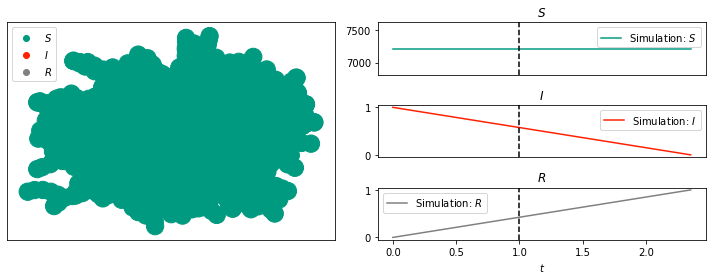

In [10]:
fd.display(time= 1)

In [11]:
ttree = fd.transmission_tree()

In [12]:
ttree.edges()

OutMultiEdgeDataView([])

## We can inspect the contagion tree to replicate contact tracing

In [13]:
pd.DataFrame(fd.transmissions())

,0,1,2
0,0,None,n4624


# Retry now with a SEIR model

In [14]:
import numpy as np
from collections import defaultdict

In [37]:
#experiment on a small network
#N = 1000
#G = nx.fast_gnp_random_graph(N, 5./(N-1))

#use the nohoch CDMX network

G = nx.read_graphml(path="/home/gdj/GITS/ModularReopeningCDMX/g_cdmx_infomap.graphml")
G = nx.convert_node_labels_to_integers(G)
#N = len(G.nodes(G))
#G2 = nx.fast_gnp_random_graph(N, 5./(N-1))

#G2 = nx.Graph() # or whatever type of graph `G` is
#G2.add_edges_from(G.edges())


In [38]:
#one arbitrary time unit will represent 1 hour. 
#24 arbitrary  time units = 1 day

#Transition from exposed to infected is variable, between 24 and 48 hours 
#transmission weight is variable (ie, representing viral charrge, length of contact, etc)
#and edges will vary in transition rate.
#there is no variation in recovery rate.

#node_attribute_dict = {node: 0.5+random.random() for node in G.nodes()} 
#edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()} 

#Stochastic transition E-I 
ei_node_attribute = {node: random.uniform(a=0.5, b=2) for node in G.nodes()}
#Stochastic transition I-R 
#will multiply recovery rate for some factor so it is between 14 and 28 days 
ir_node_attribute = {node: random.randint(a=1, b=2) for node in G.nodes()}

#Transmission weight - varies for each pair of interactions (some contacts are very transmisive, others not so)
edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()} 


nx.set_node_attributes(G, values=ei_node_attribute, name='expose2infect_weight')
nx.set_node_attributes(G, values=ir_node_attribute, name='infect2recove_weight')
nx.set_edge_attributes(G, values=edge_attribute_dict, name='transmission_weight')
#These individual and partnership attributes will be used to scale
#the transition rates.  When we define `H` and `J`, we provide the name
#of these attributes.




In [39]:
### rates


#ei_rate = 1/36 # so that minimum rate is 12 hours, maximum is 72
ei_rate = 1/1.5 # so that minimum rate is 12 hours, maximum is 72
#ir_rate = 1/(14*24) # so minimum time is 14 days, and maximum time is 28 days
ir_rate = 1/(14) # so minimum time is 14 days, and maximum time is 28 days

transmission_rate = 0.155 #this represents the baseline transmission. Let's use the one we used with SEIRSplus
#transmission_rate = 0.030
#transmission_rate = 0.00125
#transmission_rate = 0.0025 ORIGINAL YY
#transmission_rate = 0.0040

In [40]:
#We show how node and edge attributes in the contact network 'G' can be used
#to scale the transmission rates.  More advanced techniques are shown in
#other examples.

#the node intrinsic transitions
H = nx.DiGraph()
H.add_node('S') #This line is actually unnecessary since 'S' does not change status intrinsically
#
H.add_edge('E', 'I', rate = ei_rate, weight_label='expose2infect_weight')
#
H.add_edge('I', 'R', rate = ir_rate, weight_label ='infect2recove_weight')

#interaction depending transitions
J = nx.DiGraph()
J.add_edge(('I', 'S'), ('I', 'E'), rate = transmission_rate, weight_label='transmission_weight')
#  The line above states that an 'I' individual will cause an 'S' individual
#  to transition to 'E' with rate equal to 0.1 times the partnership's attribute
#  'transmission_weight'.

In [41]:
IC = defaultdict(lambda: 'S')
for node in range(10):

    IC[node] = 'I'
    
return_statuses = ('S', 'E', 'I', 'R')

In [42]:
my_results = EoN.Gillespie_simple_contagion(G=G, 
                                            spontaneous_transition_graph=H,
                                            nbr_induced_transition_graph=J, 
                                            IC=IC, 
                                            return_statuses=return_statuses,
                                            return_full_data=True,
                                            tmax=1000
                                            )

In [43]:
my_results.summary()


(array([0.00000000e+00, 1.23440871e-01, 3.77992346e-01, ...,
        1.53222029e+02, 1.58026527e+02, 1.68855948e+02]),
 {'S': array([7206, 7206, 7205, ..., 2940, 2940, 2940]),
  'E': array([0, 0, 1, ..., 0, 0, 0]),
  'I': array([10,  9,  9, ...,  2,  1,  0]),
  'R': array([   0,    1,    1, ..., 4274, 4275, 4276])})

In [44]:
#my_results.animate()

In [45]:
pd.DataFrame(my_results.transmissions())

,0,1,2
0,0.377992,2,13
1,0.513416,0,3867
2,1.837636,9,6434
3,1.993796,6434,6667
4,2.057521,6434,6274
...,...,...,...
4261,130.894397,5630,5627
4262,130.910876,1243,1269
4263,130.948642,5637,5634
4264,139.298369,5634,1255


In [46]:
#my_results.display(time=40, )

In [47]:
my_results.summary()[0]
#type(my_results.summary()[1])
#my_results.summary()[1]["S"]

predata = my_results.summary()[1]
predata["t"] = my_results.summary()[0]

df = pd.DataFrame(predata)
df = df.assign(I_pc=100*df['I']/len(G.nodes()))

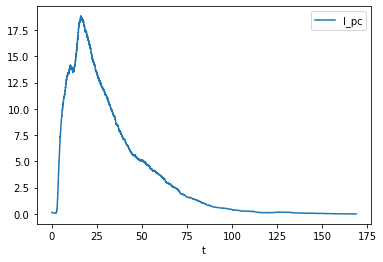

In [48]:
df.plot(x="t", y="I_pc")

## Contact trace


#### Define functions (From communication with YY Ahn)

In [49]:
from collections import Counter


def nodes_with_given_state_at_time(t, s, sim_data, node_set):
    """Return a set of infected nodes, out of `nodes` provided."""
    return [
        node for node, state in sim_data.get_statuses(node_set, t).items() if state == s
    ]

def trace_contacts(t, sim_data, G, p_sample, p_neighbor):
    """Perform contact tracing.

    Sample p_sample fraction of infected nodes at time t, and then trace
    some of the neighbors of these sampled nodes.
    """
    infected_sample = sample_infected(t, p_sample, sim_data, G.nodes())

    cnt = Counter()
    for node in infected_sample:
        for neighbor in G[node]:
            if np.random.random_sample() < p_neighbor:
                cnt[neighbor] += 1
    return cnt


def sample_infected(t, p_sample, sim_data, node_set):
    """Sample p_sample fraction of nodes from infected people at time t."""
    infected = nodes_with_given_state_at_time(t, "I", sim_data, node_set)
    return np.random.choice(infected, int(len(infected) * p_sample))

### We contact trace some people at day 14 (passive detection)

In [50]:
t=14
cnt = trace_contacts(t, my_results, G, p_sample=0.5, p_neighbor=0.5)
traced_1 = [x[0] for x in cnt.most_common(30)]
traced_2 = [x[0] for x in cnt.items() if x[1] > 1]


In [51]:
traced_2

[2366,
 4377,
 5228,
 5794,
 5941,
 5942,
 5943,
 5947,
 6021,
 6048,
 6085,
 6104,
 6112,
 6174,
 6177,
 6179,
 6189,
 6192,
 6201,
 6202,
 6216,
 6227,
 6233,
 6239,
 6241,
 6247,
 6248,
 6272,
 6281,
 6293,
 6303,
 6305,
 6308,
 6313,
 6339,
 6345,
 6348,
 6359,
 6365,
 6383,
 6399,
 6407,
 6419,
 6427,
 6446,
 6459,
 6468,
 6471,
 6486,
 6504,
 6506,
 6513,
 6517,
 6518,
 6519,
 6521,
 6531,
 6545,
 6607,
 6608,
 6611,
 6616,
 6622,
 6623,
 6625,
 6628,
 6657,
 6706,
 6710,
 6727,
 6736,
 6745,
 6749,
 6755,
 6795,
 6854,
 6861,
 6900,
 6902,
 6904,
 6906,
 6931,
 7000,
 7006,
 7012,
 7029,
 7045,
 7066,
 7078,
 7113,
 7167,
 2734,
 2740,
 2763,
 2764,
 2775,
 2786,
 4248,
 5454,
 6049,
 6106,
 6207,
 6209,
 6217,
 6278,
 6343,
 6361,
 6400,
 6401,
 6418,
 6420,
 6448,
 6462,
 6550,
 6615,
 6629,
 6664,
 6725,
 6728,
 6740,
 6761,
 6774,
 6792,
 6793,
 6794,
 6797,
 6798,
 6799,
 6856,
 6866,
 6882,
 6883,
 6924,
 6966,
 6999,
 7010,
 7051,
 5847,
 5949,
 6210,
 6360,
 6478,
 6568,

In [52]:
my_times = range(0, int(round(max(my_results.t()))), 10)


my_states = []
for t in my_times:
    my_states.append(my_results.get_statuses(time=t))


In [53]:
states_temporem = pd.DataFrame(my_states)
states_temporem = states_temporem.assign(t = my_times)
states_temporem

,0,1,2,3,4,5,6,7,8,9,...,7207,7208,7209,7210,7211,7212,7213,7214,7215,t
0,I,I,I,I,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,0
1,R,R,R,R,R,R,I,R,R,R,...,S,S,S,S,S,S,S,S,S,10
2,R,R,R,R,R,R,R,R,R,R,...,E,I,R,R,I,I,I,I,I,20
3,R,R,R,R,R,R,R,R,R,R,...,I,R,R,R,R,I,R,R,I,30
4,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,40
5,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,50
6,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,60
7,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,70
8,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,80
9,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,90


In [54]:
### full (may take some time and some space)

In [55]:
my_times = my_results.t()

my_states = []
for t in my_times:
    print(t)
    my_states.append(my_results.get_statuses(time=t))
    


0.0
0.12344087138585357
0.3779923458552592
0.487106107551014
0.5134156000541803
0.8310791512537765
1.3425468665448106
1.6548744211591124
1.8376362799508035
1.9347608922919544
1.9937957643821613
2.057521161006254
2.066742388383458
2.1766124652839873
2.18692810414219
2.2101249983119255
2.2390175900947265
2.243937723324837
2.244481626551056
2.2467202277794476
2.2618281143717365
2.263989236834188
2.298354598857504
2.298627552177804
2.3008096308397565
2.319745037450808
2.3268197720040535
2.341146822441279
2.3728255874623323
2.3818079633288827
2.405758846089856
2.4290343919626842
2.4372802743136943
2.442779432242941
2.4455713712424543
2.4461123642084526
2.4516377656156387
2.459389707545775
2.466037874311653
2.46865035024874
2.470851720436382
2.4725411009377587
2.47323007365499
2.4753458013076175
2.476838587739904
2.480465459821698
2.4889158851174997
2.4973373288309704
2.4975833829594536
2.4991980940158562
2.5057016064795463
2.50928990082692
2.524776305515657
2.5312148665193135
2.543776690058

3.1367285841133423
3.136759480193704
3.1392566300701468
3.139586050350944
3.141290555637188
3.141448229704761
3.1419249777916542
3.143346868832866
3.1453279475817117
3.1454762619852032
3.145932170300801
3.1459786079887193
3.1493444584278576
3.1497329186132035
3.1503432298168725
3.153033309703387
3.1538258906994145
3.1544107017812233
3.155958416902843
3.157131871584917
3.159981414446466
3.162304715930645
3.1624148842718536
3.1652217525945083
3.165512450343325
3.1660164095181123
3.1661568534595275
3.1670591525990823
3.1673498079844684
3.1691429027130122
3.1706134472917467
3.1710027782739347
3.171633109409811
3.172127062021265
3.173526520699769
3.173561640454899
3.1737320310059
3.1752426770269806
3.1763344536323013
3.1788647994123065
3.1790735786085738
3.179848854960056
3.1803747442806762
3.182538439654699
3.1826257435064553
3.18300453183565
3.1856128473423113
3.185692189940009
3.1874539649692237
3.187549770285756
3.188266460831799
3.188777119391986
3.1890610058403985
3.1910869081400572
3

3.5631742342102255
3.563939293449605
3.5641306559146635
3.5643224872397723
3.564340096617264
3.5650178291664725
3.5687598045279567
3.5691709368114695
3.5693970528684154
3.569426869147974
3.5701498511930447
3.5704806209013835
3.571964853972999
3.573223332084227
3.575806965923723
3.576505987459919
3.577889346970959
3.5780400169103492
3.578974193302287
3.5795404727558364
3.5796828173375
3.579734250998591
3.5801123900898975
3.5805114765975654
3.581051243009042
3.581143530477853
3.5819410482679173
3.582119128707032
3.5833165310805764
3.586099912372759
3.5880350192704205
3.591453908290524
3.5920455780745306
3.5943650437121737
3.595115878935878
3.5955215039879205
3.59638133622802
3.596393044235653
3.59704021315786
3.597304220324147
3.5995391591437516
3.5997531766908457
3.600012881773218
3.60025083834393
3.602429445969455
3.6026419938623317
3.6033291736815474
3.6035277448112
3.6040390667214934
3.6048750782069665
3.604988105561324
3.610073612593379
3.613931418739113
3.6140266610514566
3.6141841

4.198513441871423
4.199183587178241
4.201847790464755
4.202070811712738
4.202408958913009
4.206211256085503
4.211849325158313
4.21348666878857
4.218202497972186
4.2185895400048
4.2194798313740405
4.223686439425084
4.225786551302698
4.23385185336776
4.242388597381456
4.2437936109179155
4.246058626687458
4.246528789688834
4.248546676196253
4.253157513749201
4.253685299636501
4.25391506010652
4.254798029537479
4.257362026887943
4.261950849253138
4.262752638310152
4.266334165326907
4.2664016820443065
4.269896741221836
4.271863107176033
4.272010709269874
4.274343901308257
4.275300687698024
4.27579941032632
4.276020880379886
4.277354637454344
4.27778516862362
4.2788663321644025
4.282664106922825
4.283128460940538
4.2833721508652935
4.284348745419388
4.287183193124972
4.289488261380524
4.290094004846607
4.297022825099007
4.30521339338131
4.31455324420186
4.318254091802882
4.319444044223235
4.319534732055374
4.3237778829363975
4.323926596147483
4.324407014186546
4.324602285203083
4.32520742071

5.19900963786633
5.202642706588637
5.205199331882846
5.2074694347423325
5.208286736113917
5.214109444406432
5.214668456768177
5.216555375327101
5.218095960815758
5.218283502675853
5.219311724592963
5.220089318134883
5.223595867256411
5.226149301934866
5.232748279334315
5.2335998222007225
5.2337491820705315
5.2367044709573225
5.243925759807615
5.245803954300789
5.248713276320357
5.2590641187445435
5.259609277811461
5.259645655409541
5.26127212638888
5.264242090650553
5.2644573938891766
5.264774293980085
5.27103601742889
5.272065897627182
5.273523858054802
5.2757919430294224
5.277898589673341
5.281203238729611
5.285353159102628
5.291228181730731
5.292092539567303
5.293111257156697
5.294653092240565
5.297579137610036
5.298675059177174
5.299084166364942
5.299342740913143
5.300753725926743
5.300950295499675
5.301528239281291
5.304335900763858
5.306149013543747
5.314563402581163
5.315598796173267
5.321065415226712
5.323631322893742
5.325539286593305
5.328244461569252
5.329605037775103
5.3304

6.420035609457444
6.423000894767073
6.423730756872908
6.42427199729036
6.425214945722461
6.431225476978216
6.435849591921988
6.438840034518342
6.443961470629273
6.449630774707648
6.450647229732049
6.451256887972196
6.452876443302828
6.453086763262034
6.458757197370309
6.4600947832711295
6.462173355324564
6.46384793824343
6.465250906595392
6.473433526786089
6.4798858102850545
6.479918394324112
6.482524678237556
6.487132107884145
6.495876003250135
6.499524991316216
6.502800937777054
6.505804039027947
6.50870530290641
6.5090965989057095
6.5131770509714695
6.520428932179023
6.5241003879495665
6.524112527581776
6.526680713733648
6.5330030516471185
6.535461150207661
6.535471038422619
6.5367007174290555
6.539220022322018
6.540184531018448
6.543349733908663
6.54357719515348
6.547341387755957
6.549044584979097
6.551951248588005
6.555216161422709
6.556177346681847
6.5567027761605035
6.55676529988039
6.561680118499378
6.561812450129128
6.5675919622583825
6.569141443324689
6.572316584623629
6.5723

7.687812219757565
7.6896065188655305
7.6897528182936465
7.691193038590639
7.6965168838596005
7.705046578548817
7.705450944059389
7.705549471511671
7.706029329133126
7.707315829021048
7.712248677783983
7.715685067367622
7.719084571770473
7.723791188280861
7.723989567895822
7.72415908708001
7.724910039143922
7.727350904988455
7.727789549495455
7.729083680477938
7.731524398931428
7.73242174377121
7.732506726623118
7.7352513364831195
7.73556832128761
7.7364368428110275
7.736971882813607
7.737316497574224
7.737964790267617
7.740570686384071
7.752480758907947
7.752903847063982
7.754138364960069
7.754698220869448
7.754981441962345
7.756045561925953
7.758875230694117
7.760276924860521
7.760822178690741
7.762465505514702
7.765492760878169
7.766659452522425
7.770509705829177
7.771364562661899
7.774466276966231
7.776774424125074
7.776844153521851
7.7806218885212415
7.781440873605174
7.78375616669601
7.7882917286657705
7.800726022497251
7.801459039943608
7.8019046067146665
7.802672944558706
7.8031

9.027580729589017
9.03042786834758
9.030632212413096
9.032576529412468
9.036131214402614
9.03664591467151
9.039285444798574
9.045991007047679
9.047721448077787
9.049637483655319
9.051042055287578
9.056272311930146
9.061592798750151
9.062511478371409
9.072873914437487
9.07548115921698
9.080728470848406
9.080756395786633
9.081145371262565
9.086884277454015
9.088673680609807
9.089111311943265
9.09117508685107
9.095063600791313
9.102677377352004
9.10377901080583
9.104029795489009
9.106298447426175
9.108011869245965
9.11154652966805
9.11209901571899
9.118561415117643
9.120125363634818
9.12325630918472
9.123572498700597
9.124727139215201
9.125860138152492
9.12617210667108
9.133580016918094
9.137546476731071
9.140090569611145
9.141560995375578
9.150118350113658
9.16239864834731
9.163844947113184
9.164250254952176
9.167721103280627
9.171948531677732
9.174277614063497
9.177744618107571
9.179823142757792
9.184422834473532
9.187864879165486
9.18973733596402
9.19212325349302
9.192856263143122
9.19

10.356282973954269
10.35712984544979
10.359009485087542
10.359257837522792
10.361496829857215
10.361640921289036
10.365764541400619
10.366992038951285
10.367607738608362
10.368727339050292
10.37083096261957
10.371258341670568
10.373950943003653
10.374958439565361
10.377835101349191
10.378563735759812
10.378962095440583
10.380255849459443
10.383699562188086
10.386911010759974
10.38734497392534
10.388977033347327
10.39594049725346
10.400761589726667
10.40751118831948
10.407678921107257
10.40828867401764
10.411741868125711
10.413475406504077
10.416592502571369
10.41683996437351
10.418325537912724
10.42504008847923
10.425154248266058
10.426374731748131
10.427847268776727
10.42944832327341
10.440709358384265
10.441312477903216
10.443315358987663
10.445341198426894
10.447543527580695
10.451504840758792
10.454245292943728
10.455354000133255
10.45576915043405
10.46862150556511
10.470515369247634
10.478393317657407
10.48434844200709
10.484833921200696
10.487505705732483
10.489970899080328
10.49

11.68001842030704
11.6851315691744
11.68585520707491
11.690958954032832
11.692958617477085
11.697836109401713
11.698074782982394
11.703027192025953
11.706102196904279
11.70646881140253
11.712578333524112
11.71270320344433
11.716056942094244
11.717313578735283
11.718650590674661
11.72158890020588
11.724741022586402
11.726509347678395
11.72695299553238
11.731878140309107
11.740978388104352
11.748925453033095
11.751076369985444
11.754465061049405
11.755622746288854
11.756082517716024
11.757929031046947
11.760598365692507
11.773721320867711
11.77431513998278
11.777929286425387
11.778352727938302
11.781833203030281
11.782347693066175
11.783734122539528
11.786331118450835
11.786967983660796
11.789322370919686
11.789696213997333
11.791256358472303
11.792500146522029
11.797456991925893
11.797591466857005
11.80859770315179
11.80892732617444
11.809243634413724
11.81168435823856
11.816352545067042
11.827750030530742
11.830766307197544
11.832626881481945
11.834316628814545
11.83470073998702
11.835

12.765321037189347
12.765595134442487
12.76707319384829
12.7685646010673
12.768922566813488
12.771053149760071
12.7712063933733
12.7733053206505
12.773436145196653
12.774717640019492
12.774959817787188
12.775118287319899
12.775577503573917
12.777293886693062
12.779364874695888
12.780254765966884
12.780560902171786
12.780588999855343
12.780784668366028
12.781018009761215
12.781202517395752
12.784140996234811
12.789677131012548
12.789694137527542
12.79015815376972
12.790812663452284
12.793400113741107
12.795256721868794
12.795468341300314
12.796391944421972
12.801549341033432
12.808034477955173
12.808727363500743
12.808908491976638
12.809004130846766
12.811590721308082
12.813137696862478
12.813568796961142
12.814055814078412
12.818162386841907
12.818381432280898
12.819283212116556
12.821763710302555
12.822256951859199
12.82367636207428
12.823814731978866
12.827526841436296
12.834360830227785
12.836145232119533
12.84009033541304
12.842742198233063
12.84323854557982
12.843298446347703
12.8

13.455482031721376
13.45817411229063
13.458433671535172
13.460012077472358
13.462919057487944
13.464302846047268
13.465272048796114
13.466948942541787
13.467703894303671
13.46803709120248
13.470716780828154
13.472309901522275
13.472636459903756
13.475534079428778
13.47702676299585
13.480481077588191
13.481675315570852
13.48251489712267
13.482897237545782
13.482930246919546
13.487826595283396
13.489161821922124
13.490762531017536
13.492497475841208
13.493451387521123
13.493822107892386
13.494623943641011
13.498448183002866
13.499249832484914
13.504688018828158
13.50610221809464
13.508730201134126
13.508824585274123
13.509467395171004
13.51240359740959
13.514607833914502
13.515147324267216
13.517113558745047
13.517164052450958
13.517725579410854
13.5179046260795
13.520005374913314
13.521316099123315
13.52579113860235
13.527398947460513
13.529237211624869
13.530032014143071
13.531060912298766
13.53157913010238
13.531907651379282
13.533103351403078
13.533450053264414
13.534701980563323
13.

14.185223684297615
14.185882666107224
14.187103408631065
14.188952430326689
14.192242269446735
14.193998786871772
14.194107973549992
14.195263913025617
14.197589212248293
14.198585172129414
14.200236792895401
14.201905990560558
14.206031259289672
14.212611142674396
14.212880535191069
14.215698060659038
14.215755704068513
14.21707896506847
14.217290557524167
14.217663930372465
14.21993338765215
14.221294998226323
14.221742667956004
14.22221918050816
14.222275453239199
14.223685363151757
14.224841807782862
14.226746913094148
14.232568309238852
14.236240572211015
14.238611799295809
14.239252516642724
14.239469811053217
14.240977715106807
14.241326957726798
14.242808227605801
14.24353463843701
14.244091580092592
14.244719811641195
14.248273973285706
14.2483093134701
14.250081090263848
14.253625293610924
14.255818066933411
14.256944848859806
14.25844303207713
14.258446606048206
14.26092054840738
14.260982757091675
14.26199222727837
14.262275408928913
14.262910066560552
14.264536481910106
14

15.130374839928953
15.130985374854479
15.131641456695547
15.136717642210835
15.138197068127495
15.138825689083772
15.142830896588666
15.144249840369428
15.145911657876326
15.146869102000304
15.14978706006646
15.151677802664492
15.154372663271296
15.155565726517306
15.158721941568123
15.161072172542935
15.161817824562268
15.163145153158789
15.166189712529784
15.168141877782261
15.173387276289573
15.173500639123128
15.17615247811107
15.176936872801614
15.17956394218883
15.180926504184907
15.183080107183216
15.183454044768714
15.184155161957426
15.185918623435976
15.186744928833374
15.192819929064786
15.193007708601352
15.193767734676017
15.19418309254429
15.194254475910435
15.196293058978883
15.196662401825309
15.197178995717014
15.199455306372533
15.204356227641133
15.209800552992158
15.212344054322921
15.213520686587671
15.213526912319505
15.215090361957195
15.218497354740357
15.218654521667407
15.222568566971043
15.224716496520976
15.226120953256723
15.227138689724574
15.2276154708034

16.280100606882193
16.281062397067128
16.281571986807897
16.282018582334594
16.28292430755553
16.283977265121262
16.285046371784166
16.291537296512647
16.29195818883513
16.299203527357005
16.30771697747235
16.309364884713556
16.309672912950322
16.31143505674872
16.31462546821459
16.315541837179637
16.317186571766445
16.31794015810783
16.31801649870695
16.320507946041314
16.325655989961813
16.328821578785917
16.33023569189873
16.33363282076494
16.33877299934828
16.33892459422475
16.341210386825352
16.341929351876185
16.34336099683518
16.34565669390091
16.351545574512574
16.353400371328867
16.354736621745374
16.356779298803556
16.362578793359997
16.37008964692451
16.371244762206477
16.372656515406
16.373174472364493
16.3732467598267
16.37386777077239
16.37525631678791
16.375783150466937
16.37892161878316
16.38842806563464
16.394458374480823
16.396045818656688
16.404987551051924
16.409237952594484
16.411027161936723
16.417944843069222
16.41894996438801
16.419351349701383
16.42027117686837

17.852068847106132
17.85566286738828
17.863066682749185
17.869140770682755
17.87240524972908
17.885524354972496
17.88796732668497
17.894618188886703
17.89629554920039
17.90122642480261
17.902158835705702
17.903626847827507
17.91443997389284
17.91741031157013
17.926772240520776
17.92691202832443
17.93514982003541
17.938881402283844
17.942129488518933
17.9488462173641
17.949941481346123
17.951873964990824
17.95925017844693
17.95983938076955
17.971208008418092
17.97307363997727
17.975251490488407
17.975422417701687
17.978295484144294
17.97936847363327
17.980844316973386
17.98980076694939
17.991445993301202
17.991672243725088
17.992632359442588
17.99369198638439
17.998611905018887
18.000814967489156
18.002704461777576
18.006674009071922
18.008242275094492
18.009550240385472
18.01659352532054
18.02437917818683
18.028130709541
18.03058976724622
18.032969946261513
18.03563522454598
18.037230120295742
18.045342431709955
18.046184672363925
18.048648424932242
18.049664156266054
18.05415100333719

19.641440076971577
19.645929961272998
19.653081795755792
19.665828481470143
19.668561288832304
19.672667310571562
19.673091364214716
19.676842032367198
19.680470661170943
19.681792505600285
19.681989268854153
19.682359614461834
19.68421131565588
19.690257583891913
19.693887810424975
19.69396141084285
19.695704285853257
19.702778611526014
19.704565430284642
19.710192662369217
19.71501974803292
19.715488636445556
19.722791635531394
19.729499731700436
19.729736897462374
19.7317867291219
19.734873906378436
19.738503769085508
19.74125050389565
19.74190408318624
19.74348044856388
19.74493525454696
19.749878722657154
19.75190709087261
19.758788174192933
19.760737595604407
19.762831801636793
19.7628962971718
19.763374164939076
19.763606830638896
19.764274070621568
19.76471107456816
19.78325067816385
19.783491909156144
19.791873584473386
19.796036727278423
19.796424083954598
19.799258690301837
19.799851592276674
19.80660408105656
19.807582871107083
19.81072220853901
19.81222215032573
19.8128463

21.50188142626051
21.50436086053274
21.505663779836283
21.515041139942877
21.525123345559795
21.528584526185277
21.53085674132819
21.532758793045655
21.532918828034333
21.545594963283193
21.550538945011755
21.561913015680844
21.567593985506534
21.576657234352393
21.577875802566908
21.579630802163358
21.581065183082025
21.58169446833428
21.587427279180503
21.589451741074196
21.594781593153478
21.596907824492778
21.605075090528846
21.607518766031866
21.60832082003228
21.613851178323763
21.61804293251132
21.62598744127702
21.632417205566547
21.63701067018842
21.637670982555466
21.649280303816848
21.65177987474669
21.658309642290046
21.662470685874492
21.663012833893713
21.663235913736493
21.6706546310463
21.67098566162786
21.671493190039122
21.674359694710766
21.678895826689793
21.682754466403722
21.683402853768463
21.686080067228637
21.689419064889165
21.695411602947537
21.702454854666534
21.706524384410052
21.70772004221283
21.716411350588732
21.716637629325447
21.73349365405608
21.7342

23.587489423573814
23.59408509064078
23.594278105282132
23.604649630784916
23.612025372416863
23.6141082088858
23.624357642127624
23.624581724758162
23.62550356239619
23.627147829163317
23.62865783573099
23.6351295517921
23.66500894119831
23.668979764529503
23.670013331865242
23.671327431568326
23.67159234016109
23.672131625267223
23.675278869092967
23.67543214950268
23.68040138545656
23.68446522004342
23.686325744952303
23.694400157672348
23.696973817395403
23.697275987714285
23.72068367402976
23.73298999033398
23.733486372719067
23.741861672032766
23.743317887999034
23.771413460312534
23.778252424216568
23.780690673727257
23.780872510588477
23.783774458108145
23.799723499728916
23.800544722318183
23.804059958334477
23.808578242530082
23.810629299917665
23.816502401730688
23.81785733913057
23.83073124499827
23.835603359176105
23.83563522095357
23.836535086385588
23.83959618673638
23.841524609509417
23.850028148650168
23.853777708205648
23.853819113392632
23.85397491344616
23.860162466

26.13162683659951
26.139712518398845
26.140901617743708
26.155767131771025
26.15622330580423
26.162846989046084
26.16746381628862
26.16936524742781
26.170220987085695
26.171900262175384
26.18514625663615
26.188758569078754
26.18927693265542
26.18931399913071
26.206038885704185
26.212832223231896
26.216837490595893
26.22249967622005
26.22494565379524
26.242809642827694
26.245822525055704
26.26065078493869
26.266455460353345
26.27009232157386
26.275952762075327
26.27846609338406
26.28863803704826
26.28910155418991
26.29209143266872
26.301226135732943
26.31063655736257
26.310971205290063
26.326920753019348
26.32728631677269
26.330515609085133
26.333405679397128
26.34688905030723
26.34753387481062
26.36352408262807
26.36360072906633
26.36414289525057
26.3810826835661
26.38358818535427
26.389570363193865
26.389761308269996
26.38995284040561
26.395318961114057
26.409724912507617
26.409901196371347
26.4117507070145
26.413265796844374
26.416430457176677
26.424565778922485
26.424753562797413
26

28.637959133009414
28.638789679507493
28.652338003869062
28.663089608234948
28.67067074366667
28.686473122007417
28.693839718018165
28.70405967797761
28.707596067466298
28.717871804273816
28.718987573383703
28.71979442175696
28.724393391570374
28.737648965979666
28.742418364360454
28.743013152343458
28.744993538153675
28.74773928445945
28.753408162919854
28.759927008423837
28.76137400488809
28.771877448109525
28.77899777485547
28.786014909191476
28.787668184316107
28.788088640857165
28.797534813518986
28.817887287810652
28.8217681431063
28.825102639549915
28.838851578259913
28.845727280775538
28.858497958180717
28.866692732544916
28.869948641798484
28.87613019342178
28.88313953628017
28.89518734792547
28.898425654432565
28.90772182739502
28.91068700040402
28.917173834411198
28.918553052734154
28.921968251231814
28.92636227221826
28.951591760731013
28.95393159536683
28.95466662476218
28.962157929768093
28.962507566235818
28.970386012275828
28.9713584417009
28.97993649041135
28.996157022

31.67848921258889
31.682077472174253
31.696398858586925
31.701159268908924
31.701523176851552
31.702263667671836
31.7028532226926
31.70802837028619
31.711956768739828
31.717641207272003
31.719554950146694
31.725942354846232
31.736751330452545
31.737507853694996
31.73942722320643
31.741245158102227
31.749726320972155
31.751754336529256
31.75542399729452
31.75600594887781
31.75613827732583
31.764224681314094
31.771996377455462
31.77288009795527
31.78432493921699
31.790166335614682
31.793065767025325
31.800112664516927
31.807174759027713
31.81604546418332
31.82245278289689
31.826604538097246
31.83877618392046
31.846950289894895
31.84820943148803
31.85400995453121
31.89140934543387
31.904227008411876
31.912546305125936
31.921104141160942
31.92482067984483
31.92621268347798
31.940321185406543
31.962579707809674
31.967192208256915
31.968316092461553
31.969712140164564
31.972886772359985
31.976886259756554
31.977843777261437
31.99130025481933
32.003342564736435
32.00645085706837
32.0114085089

35.26132434332603
35.272143365583744
35.27432865551807
35.286322710757105
35.2952492454516
35.2966093818617
35.29729569709138
35.315062344727515
35.32615591650397
35.33130420772758
35.359809868130675
35.360496541161126
35.361421866322694
35.38555463001497
35.40521003000589
35.41072530884535
35.414548608801304
35.41457964561503
35.41904570780024
35.421269028277436
35.4421768825576
35.459212235313274
35.46472186129211
35.46472888680727
35.464780854828476
35.480623452885844
35.486690022354495
35.488865208238074
35.4930585338233
35.49557950568717
35.502785169733215
35.50696064429664
35.50798822523725
35.523827721785985
35.53752592237868
35.53784671078884
35.53815231444559
35.54250287734579
35.54698684371315
35.55473702540533
35.55872811703416
35.56423634923744
35.568246428429966
35.57879834011538
35.585782768398175
35.58743084707661
35.59347315158502
35.60707525715022
35.6083307897145
35.61662509711418
35.61688594726698
35.63221270906908
35.64787895044467
35.647965961394654
35.648286190607

39.47068705831791
39.48356202253224
39.49016866049004
39.50340367695402
39.50783419100383
39.513169901887224
39.51394939702258
39.52661537069702
39.52764214933136
39.52798769360881
39.54805973350638
39.5585620827138
39.56700906150228
39.58418249920204
39.58616189795352
39.59734390783863
39.601058067159
39.60740442908749
39.617692102795075
39.62996559949932
39.644412026167004
39.66342130207601
39.66666496881487
39.680630757021234
39.68495927080884
39.69723923000009
39.70707807682376
39.71169131825953
39.733136069909264
39.74208457691304
39.7563654477375
39.76539305342753
39.77292626345871
39.774818046658815
39.77515722228304
39.7909882282612
39.79818118644803
39.81059199969621
39.836160736843084
39.839347948109435
39.873521124282256
39.88842054894976
39.89058283985134
39.89355712419427
39.91035595081505
39.9299017616814
39.943869834775256
39.97564161989611
39.98285380714429
39.99726046393865
40.04195103769496
40.05862815740835
40.070259777468294
40.08828909119948
40.1071861440452
40.113

45.33698853995682
45.354853816040084
45.36792418033496
45.38087234349793
45.38862182668672
45.38981378620512
45.39310718283831
45.39499635226942
45.44545899818964
45.44552629221592
45.4580346737974
45.474448876025676
45.48505477761408
45.50652503887743
45.508386393607424
45.51583533464021
45.522427385900656
45.53035252124626
45.54310356413171
45.59344612300725
45.60385704394414
45.60743636306803
45.61521240880685
45.623455051552526
45.63091555606994
45.66122345248632
45.662070979518965
45.66561249729857
45.66660843532564
45.67247750086292
45.68791610094034
45.70369482731004
45.70474123733753
45.77491216003641
45.79855602585638
45.833380579174424
45.834394082973496
45.835381905396744
45.84979701913201
45.8764824009126
45.89947718287846
45.90853519072809
45.92021657705032
45.99896074392917
46.01415273392997
46.037064954274356
46.04931811939792
46.075852349105205
46.08892827819697
46.11480706953322
46.115740739981725
46.12659109107343
46.129460147029604
46.12957156821337
46.15295578763695

52.116911161127135
52.11743556056964
52.12636096666871
52.13590740083585
52.148279858036084
52.1701339229185
52.175286489897964
52.17808821131305
52.18521692094162
52.2046939507379
52.226922106369784
52.263326715101236
52.26713152331866
52.27135421094491
52.27218373898943
52.27703189264249
52.29992931419273
52.337636026011396
52.3442420445424
52.35774242604999
52.36278903299907
52.379810600746254
52.38056137784457
52.380881617158465
52.396652645221394
52.43192805985188
52.43562949372044
52.438438982781086
52.44162910690107
52.45383872732484
52.45416906627242
52.46215036252136
52.47051599384911
52.47558016851024
52.479645226182015
52.48128489054776
52.485930621575584
52.49641697953351
52.52603211519415
52.55432479549218
52.559081274342994
52.56625750326227
52.57530332487895
52.61638487490413
52.63199284171968
52.656181790167295
52.69124324442522
52.731866788307784
52.73517160549269
52.73905387855917
52.7702566994462
52.77156738928823
52.77839421385739
52.7992842380104
52.82486583961501


60.9578588177022
60.961942461758326
60.97405158576568
60.9869278684928
61.00091042869073
61.039864722437635
61.05805074673024
61.12128036632877
61.13677715847699
61.137964656647846
61.160384207897685
61.16754021656142
61.190089551670354
61.25702125799038
61.28129468139528
61.35400286643726
61.39752792939556
61.41538129509837
61.440588794576854
61.47050825587394
61.494797768986416
61.49808119030008
61.539053819929485
61.54847331383631
61.56636440022839
61.577204687009015
61.610842567656825
61.66621340345221
61.67001957916121
61.68125289259118
61.69600854471153
61.73317028399617
61.73815145940652
61.809520589998016
61.830234874223365
61.84252813743018
61.89080181289981
61.89769704877536
61.899620838107595
61.90683101114753
61.95154446696779
61.95469632227006
61.96107342765603
61.966281708247635
61.97496294440294
61.98750546879223
61.99727653360514
61.99942420737462
62.02827999569432
62.03283350481588
62.06268052225419
62.07456906991137
62.09156594439164
62.10037765671835
62.1091681672649

79.22227232600545
79.40792607274845
79.48991246282566
79.55071677171017
79.68492903397873
79.91485558261313
79.94308602948406
79.98420296668475
80.07272250331611
80.23706736989821
80.28021740419479
80.30793944439043
80.35302862704884
80.41648331678978
80.44882467842758
80.45666307628747
80.49624775401892
80.74332962994434
80.76470955522656
80.82844756309066
80.97709721435699
81.05082653121843
81.09633295941187
81.10219034940232
81.19679764089564
81.22588952697926
81.25835713566957
81.40063951034621
81.47807306320477
81.65221518686678
81.6886885203908
81.69445530194307
81.81400058258077
82.08183533762224
82.0971150618064
82.24636085618341
82.43242762471375
82.50629813733221
82.53966908193982
82.58950890012797
82.62312129871196
82.65088715313108
82.68020135030218
82.7293070622287
82.73983358161598
82.8411371101209
82.85010289853793
82.97752648505642
83.08554288642048
83.09048385779987
83.14066366323907
83.422618680084
83.49555136281931
83.56732876291262
83.632471330433
83.651215007507
83

In [56]:
states_temporem_full = pd.DataFrame(my_states)
states_temporem_full



,0,1,2,3,4,5,6,7,8,9,...,7206,7207,7208,7209,7210,7211,7212,7213,7214,7215
0,I,I,I,I,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,S
1,I,I,I,R,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,S
2,I,I,I,R,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,S
3,I,I,R,R,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,S
4,I,I,R,R,I,I,I,I,I,I,...,S,S,S,S,S,S,S,S,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12804,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R
12805,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R
12806,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R
12807,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R


In [57]:
states_temporem_full = states_temporem_full.assign(t = my_times)
states_temporem_full.to_csv(path_or_buf="results/yy/nodeState_df_full_20210818.csv)")

### Write outs for analysis in R 

- Node status history
- Contagion tree 
- count dataframe

In [58]:
states_temporem.to_csv(path_or_buf="results/yy/nodeState_df_20210818.csv)")

In [59]:
nx.write_graphml(my_results.G, path="results/yy/red_yy_20210818.graphml")

In [61]:
pd.DataFrame(my_results.summary()[1]).to_csv(path_or_buf="results/yy/count_dataframe_20210818.csv)")